# SNR finder ANN model training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from ler.utils import add_dict_values, append_json, get_param_from_json, load_json, save_json
import tensorflow as tf

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

from gwsnr import antenna_response_array, cubic_spline_interpolator2d

In [2]:
# Uncomment to generate new data to test the model

# generating astrophysical data for testing using `ler` package
from ler.rates import LeR
from ler.utils import get_param_from_json

ler = LeR(
    npool=8,
    z_max=10,  # becareful with this value
    spin_zero=False,
    spin_precession=True,
    verbose=False,
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='inner_product',
    ifos=['ET', 'CE'],
)

size_ = 50000
ler.batch_size = 50000
ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing_ETCE.json', resume=True);

unlensed params will be store in ./ler_data/unlensed_param_testing_ETCE.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
resuming from ./ler_data/unlensed_param_testing_ETCE.json
saving all unlensed_params in ./ler_data/unlensed_param_testing_ETCE.json 


In [3]:
# let's generate IMRPhenomD (spinless) interpolartor for the snr_half (refer to gwsnr documentation)
# One of the training input is half_snr
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['ET', 'CE'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for ET1 detector from ./interpolator_pickle/ET1/partialSNR_dict_1.pickle
Interpolator will be loaded for ET2 detector from ./interpolator_pickle/ET2/partialSNR_dict_1.pickle
Interpolator will be loaded for ET3 detector from ./interpolator_pickle/ET3/partialSNR_dict_1.pickle
Interpolator will be loaded for CE detector from ./interpolator_pickle/CE/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['ET1', 'ET2', 'ET3', 'CE']
psds:  

### Input-Output generator function

In [4]:
def input_data(idx, params):
    """
        Function to generate input and output data for the neural network
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XET1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    XET2 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    XET3 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T
    XCE = np.vstack([snr_half_[3], amp0[3], eta, chi_eff, theta_jn]).T

    return XET1, XET2, XET3, XCE, XA1

def input_output(idx, params, det='ET1'):

    XET1, XET2, XET3, XCE, XA1 = input_data(idx, params)

    if det == 'ET1':
        X = XET1
        y = np.array(params['ET1'])[idx]
    elif det == 'ET2':
        X = XET2
        y = np.array(params['ET2'])[idx]
    elif det == 'ET3':
        X = XET3
        y = np.array(params['ET3'])[idx]
    elif det == 'CE':
        X = XCE
        y = np.array(params['CE'])[idx]
    elif det == 'NET':
        yET1 = np.array(params['ET1'])[idx]
        yET2 = np.array(params['ET2'])[idx]
        yET3 = np.array(params['ET3'])[idx]
        yET = np.sqrt(yET1**2 + yET2**2 + yET3**2)
        yCE = np.array(params['CE'])[idx]
        y = np.sqrt(yET**2 + yCE**2)
        
        return(XET1, yET1, XET2, yET2, XET3, yET3, XCE, yCE, XA1, yA1, yNET)

    return X, y

In [5]:
def input_data(idx, params):
    """
        Function to generate input and output data for the neural network
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XET1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    XET2 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    XET3 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T
    XCE = np.vstack([snr_half_[3], amp0[3], eta, chi_eff]).T

    return XET1, XET2, XET3, XCE

def input_output(idx, params, det='ET1'):

    XET1, XET2, XET3, XCE = input_data(idx, params)

    if det == 'ET1':
        X = XET1
        y = np.array(params['ET1'])[idx]
    elif det == 'ET2':
        X = XET2
        y = np.array(params['ET2'])[idx]
    elif det == 'ET3':
        X = XET3
        y = np.array(params['ET3'])[idx]
    elif det == 'CE':
        X = XCE
        y = np.array(params['CE'])[idx]
    elif det == 'NET':
        yET1 = np.array(params['ET1'])[idx]
        yET2 = np.array(params['ET2'])[idx]
        yET3 = np.array(params['ET3'])[idx]
        yET = np.sqrt(yET1**2 + yET2**2 + yET3**2)
        yCE = np.array(params['CE'])[idx]
        y = np.sqrt(yET**2 + yCE**2)
        
        return(XET1, yET1, XET2, yET2, XET3, yET3, XCE, yCE, yNET)

    return X, y

## For ET detector

### Get all necessary data

In [16]:
# these are pre-generated datas
# join all dictionaries into one
unlensed_params1 = get_param_from_json("ler_data/unlensed_param_ET.json")

# len_ = int(len(unlensed_params1['ET1'])/2)
# print(len_)
# for key, value in unlensed_params1.items():
#     unlensed_params1[key] = value[:len_]

unlensed_params2 = get_param_from_json("ler_data/joint_new_optsnr_ET1.json")

unlensed_params = add_dict_values(unlensed_params1, unlensed_params2)
del unlensed_params1, unlensed_params2

# snr = unlensed_params['ET1']
# idx = snr>0
# for key, value in unlensed_params.items():
#     unlensed_params[key] = value[idx]

# unlensed_params = get_param_from_json("ler_data/unlensed_param_ET.json")

print(f"size before SNR cut: {len(unlensed_params['ET1'])}")
# set SNR cut
idx_constrain = unlensed_params['ET1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['ET1'])}")

size before SNR cut: 697365
size after SNR cut: 696708


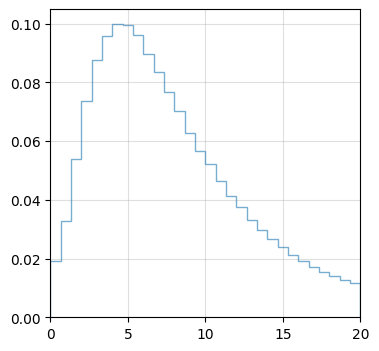

In [17]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['ET1'])
test = test[test<20]
plt.figure(figsize=(4,4))
plt.hist(test, bins=30, alpha=0.6, histtype='step', density=True)
plt.xlim(0,20)
plt.grid(alpha=0.4)
plt.show()

In [18]:
len_ = len(unlensed_params['ET1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XET1,yET1 = input_output(idx, unlensed_params, det='ET1')
np.shape(XET1)

(696708, 4)

ValueError: cannot reshape array of size 25 into shape (6,6)

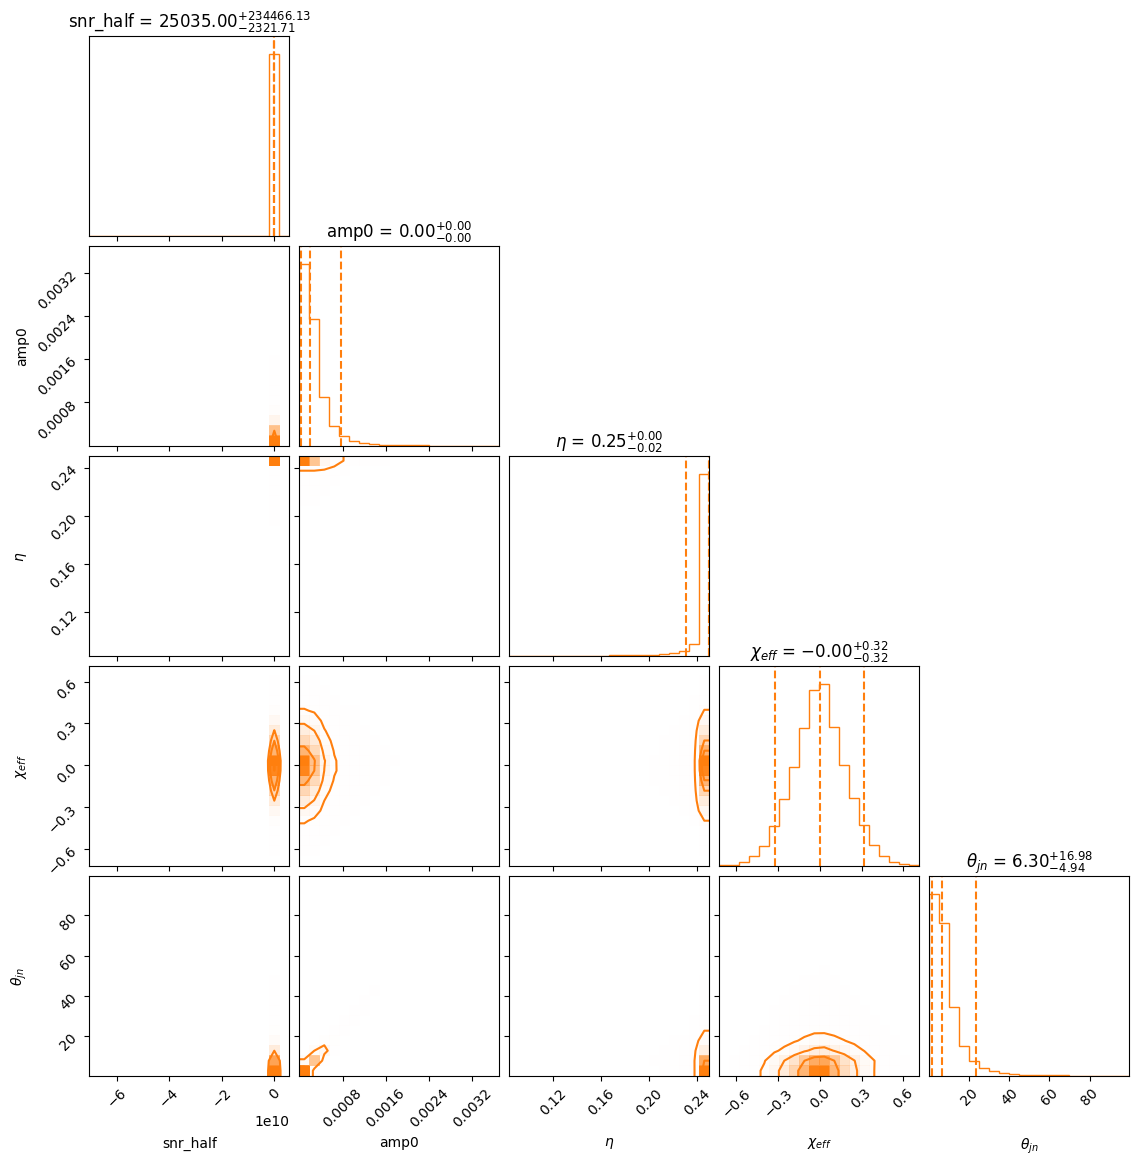

In [22]:
# plot the data to see the distribution
import corner
data_ = np.concatenate((XET1, yET1[:,None]), axis=1)

# include this point
# Actual SNR: 6.35
# SNR Difference: -4.07
# eta: 0.19
# chi_eff: 0.06
# theta_jn: 1.68
# snr_half: 2001.65
# amp0: 0.00
outlier_point = np.array([[2001.65, 0.00, 0.19, 0.06, 1.68, 6.35]])

labels = [
    r"snr_half",
    r"amp0",
    r"$\eta$",
    r"$\chi_{eff}$",
    r"$\theta_{jn}$",
    r"$\rho_{opt}$",
]
fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

# Loop over the diagonal
axes = np.array(fig.axes).reshape((6,6))
for i in range(6):
    ax = axes[i, i]
    ax.axvline(outlier_point[0,i], color='r', linestyle='--')
    

# Loop over the histograms
for yi in range(6):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(outlier_point[0,xi], color='r', linestyle='--')
        ax.axhline(outlier_point[0,yi], color='r', linestyle='--')
        ax.plot(outlier_point[0,xi], outlier_point[0,yi], 'ro')

plt.gcf()
plt.show()

* It is expected to have larger error in the sparse region of the input data, e.g. $\eta<0.2$

## Scaling the data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(XET1, yET1, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerET1_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
# sc = scalerET1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

### Generate ANN model

In [10]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step - accuracy: 0.0000e+00 - loss: 22.4051
Epoch 2/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 327us/step - accuracy: 0.0000e+00 - loss: 1.4469
Epoch 3/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 328us/step - accuracy: 0.0000e+00 - loss: 1.3754
Epoch 4/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 326us/step - accuracy: 0.0000e+00 - loss: 1.3799
Epoch 5/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 328us/step - accuracy: 0.0000e+00 - loss: 1.3687
Epoch 6/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 329us/step - accuracy: 0.0000e+00 - loss: 1.3850
Epoch 7/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 327us/step - accuracy: 0.0000e+00 - loss: 1.3452
Epoch 8/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 7s 336us/step - accuracy: 0.0000e+00 - loss: 1.3619
Epoch 9/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 326us/step - accuracy: 0.0000e+00 - loss: 1.3465
Epoch 10/100
19493/19493 ━━━━━━━━━━━━━━━━━━━━ 6s 323us/step - accuracy: 0.0000e+00 - loss: 1.3434
Epoch 11/100
19493/19493 ━━━

In [11]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelET1_final1.h5')
modelET1 = ann

In [12]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelET1 = load_model('ann_modelET1_final.h5')

### Test the Model on the test data

In [2]:
# left: predicted snr, right: actual snr
y_pred = modelET1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

NameError: name 'modelET1' is not defined

In [1]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

NameError: name 'y_pred' is not defined

In [15]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[36709  1359]
 [  731 30508]]
Accuracy: 96.984%


### Test with astrophysical parameters

In [17]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['ET1'])), unlensed_params, det='ET1')
scalerET1 = pickle.load(open('scalerET1_final1.pkl', 'rb'))
X_ = scalerET1.transform(X_)

y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
[[26888   982]
 [  721 21409]]
Accuracy: 96.594%


In [28]:
y_pred_

array([14.007063, 14.007063, 14.007063, ..., 14.007063, 14.007063,
       14.007063], dtype=float32)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


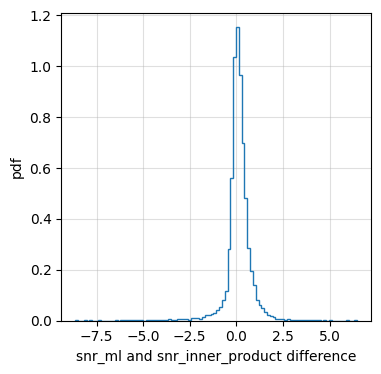

In [17]:
y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_.copy()
# y_test = Y_
hist_ = y_pred_-y_test_
idx = (y_test_>6) & (y_test_<10)  # selection wrt snr
# idx = idx & (X_[:,2]>-2)  # selection wrt eta
hist_ = hist_[idx]
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [68]:
idx = abs(y_pred_-y_test_)>5
selected_params = {}    
for key, value in unlensed_params.items():
    selected_params[key] = value[idx]

In [69]:
X_selected, y_selected = input_output(np.arange(len(selected_params['ET1'])), selected_params, det='ET1')


In [70]:
len(selected_params['ET1'])

791

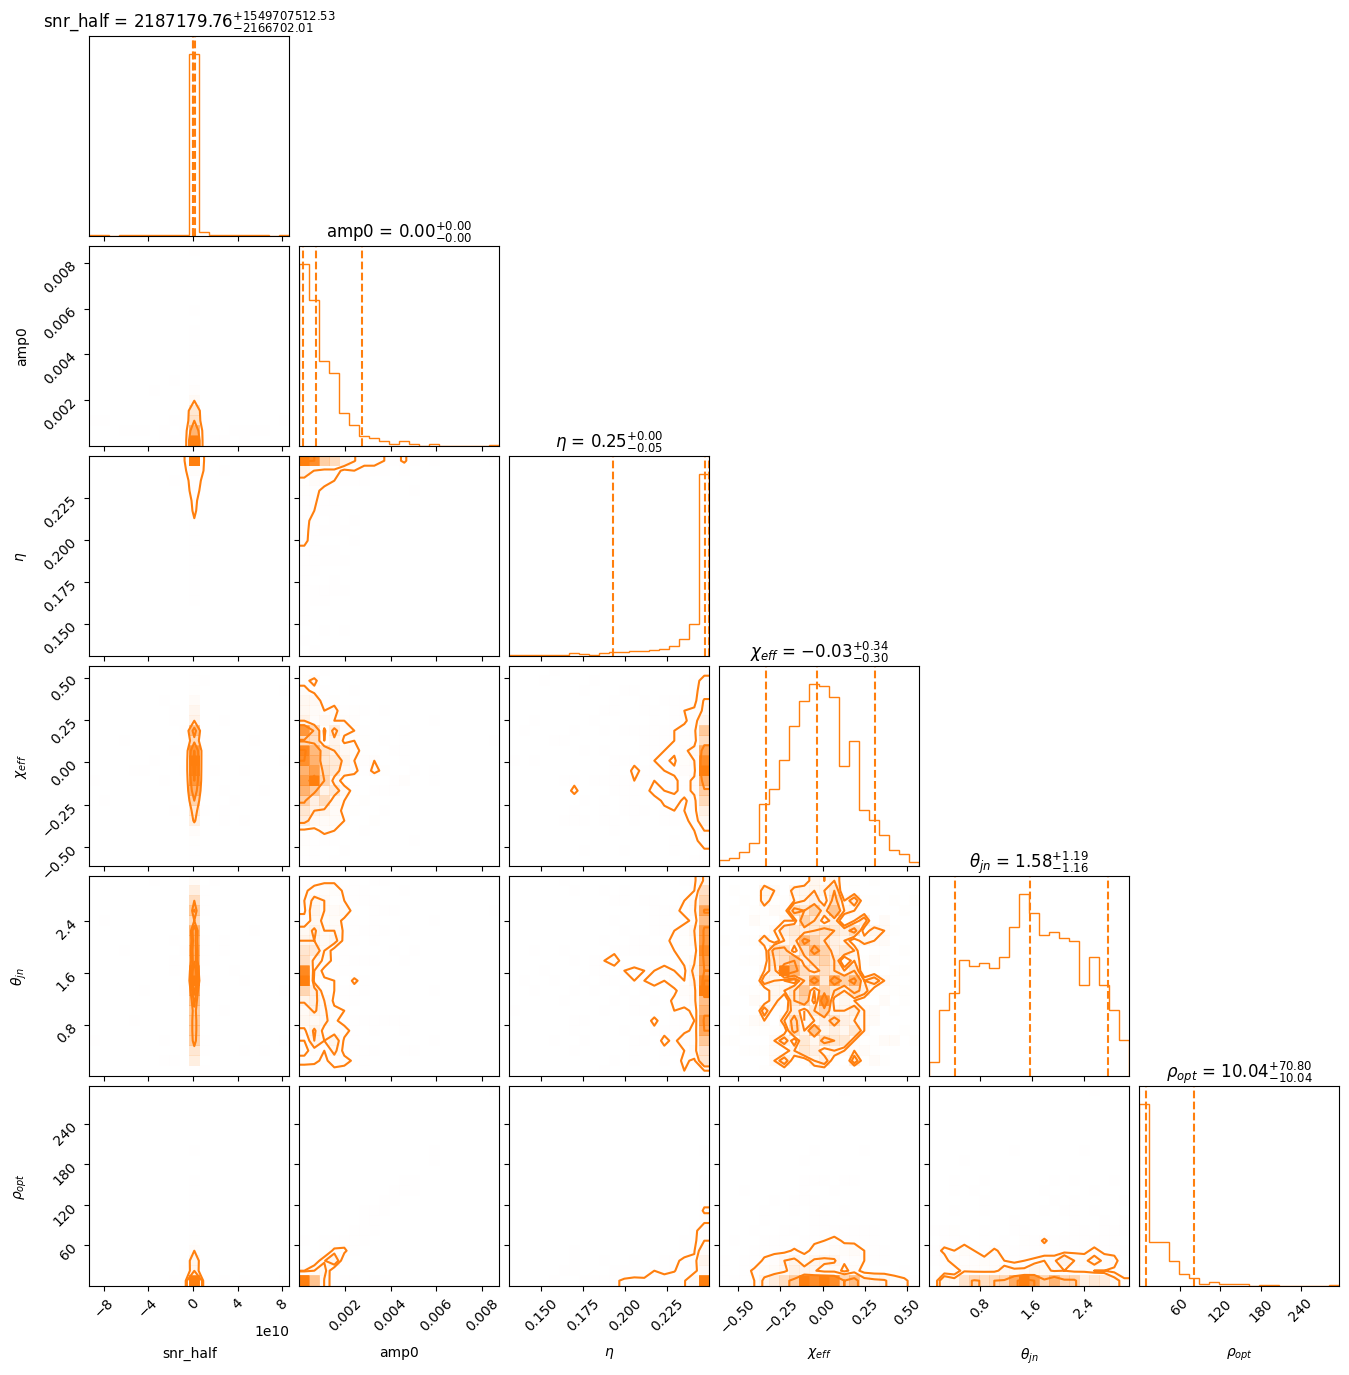

In [71]:
# corner plot
data_ = np.concatenate((X_selected, y_selected[:,None]), axis=1)
labels = [
    r"snr_half",
    r"amp0",
    r"$\eta$",
    r"$\chi_{eff}$",
    r"$\theta_{jn}$",
    r"$\rho_{opt}$",
]

fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

plt.gcf()
plt.show()

In [ ]:
y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_.copy()
# y_test = Y_
hist_ = y_pred_-y_test_
idx = (y_test_>6) & (y_test_<10)  # selection wrt snr
# idx = idx & (X_[:,2]>-2)  # selection wrt eta
hist_ = hist_[idx]
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

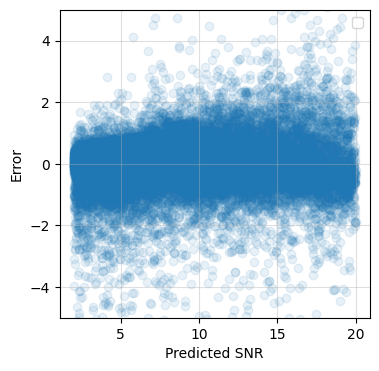

In [49]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred_>2) & (y_pred_<20)
idx = idx & (y_test_!=0)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], (y_pred_[idx]-0.0)-y_test_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-5,5)
# plt.xlim(6,10)
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("error_vs_snrET1_param4.png")
plt.show()

### Dealing with the outlier

In [20]:
# The outlier in the above plot belongs to the region with eta < -2 and theta_jn~1.6
X_outlier, True_SNR = input_output(np.arange(len(unlensed_params['ET1'])), unlensed_params)
idx_outlier = idx & (abs(y_pred_-y_test_) > 3)
idx_outlier = np.where(idx_outlier)[0][0]
print(f"outlier index: {idx_outlier}")
print(f"Predicted SNR: {y_pred_[idx_outlier]}")
print(f"Actual SNR: {y_test_[idx_outlier]}")
# mass_1 and mass_2
print(f"mass_1: {unlensed_params['mass_1'][idx_outlier]}")
print(f"mass_2: {unlensed_params['mass_2'][idx_outlier]}")
print(f"zs: {unlensed_params['zs'][idx_outlier]}")

print(f"\nSNR Difference: {y_pred_[idx_outlier]-y_test_[idx_outlier]}")
print(f"snr_half: {X_outlier[:,0][idx_outlier]}")
print(f"amp0: {X_outlier[:,1][idx_outlier]}")
print(f"eta: {X_outlier[:,2][idx_outlier]}")
print(f"chi_eff: {X_outlier[:,3][idx_outlier]}")
print(f"theta_jn: {X_outlier[:,4][idx_outlier]}")



outlier index: 41804
Predicted SNR: 2.4232120513916016
Actual SNR: 6.352815491368388
mass_1: 76.3026397448811
mass_2: 27.358556904538652
zs: 0.5480229069513276

SNR Difference: -3.9296034399767867
snr_half: 2001.6517677875127
amp0: 0.0008635692480745218
eta: 0.1942675721898456
chi_eff: 0.06450118303828369
theta_jn: 1.6779117119291895


In [21]:
gwsnr2 = GWSNR(snr_type='inner_product', waveform_approximant='IMRPhenomXPHM', ifos=['ET1'], gwsnr_verbose=False)

In [22]:
## Check which one (eta or theta_jn) is causing the outlier
# change eta or theta_jn
# find real SNR using gwsnr.snr
param_dict = {
    'mass_1': np.array(unlensed_params['mass_1'][idx_outlier:idx_outlier+1]),
    'mass_2': np.array(unlensed_params['mass_2'][idx_outlier:idx_outlier+1]),
    # 'mass_1': np.array(unlensed_params['mass_2'][idx_outlier:idx_outlier+1]),
    # 'mass_2': np.array(unlensed_params['mass_2'][idx_outlier:idx_outlier+1])*0.35855321645505783,
    # 'mass_2': np.array(unlensed_params['mass_1'][idx_outlier:idx_outlier+1]),
    # 'mass_1': np.array([40.]),
    # 'mass_2': np.array([40.*0.35855321645505783]),
    'luminosity_distance': np.array(unlensed_params['luminosity_distance'][idx_outlier:idx_outlier+1]),
    'theta_jn': np.array(unlensed_params['theta_jn'][idx_outlier:idx_outlier+1]),
    # 'theta_jn': np.array([0.8]),
    'psi': np.array(unlensed_params['psi'][idx_outlier:idx_outlier+1]),
    'phase': np.array(unlensed_params['phase'][idx_outlier:idx_outlier+1]),
    'geocent_time': np.array(unlensed_params['geocent_time'][idx_outlier:idx_outlier+1]),
    'ra': np.array(unlensed_params['ra'][idx_outlier:idx_outlier+1]),
    'dec': np.array(unlensed_params['dec'][idx_outlier:idx_outlier+1]),
    'a_1': np.array(unlensed_params['a_1'][idx_outlier:idx_outlier+1]),
    'a_2': np.array(unlensed_params['a_2'][idx_outlier:idx_outlier+1]),
    'tilt_1': np.array(unlensed_params['tilt_1'][idx_outlier:idx_outlier+1]),
    'tilt_2': np.array(unlensed_params['tilt_2'][idx_outlier:idx_outlier+1]),
    'phi_12': np.array(unlensed_params['phi_12'][idx_outlier:idx_outlier+1]),
    'phi_jl': np.array(unlensed_params['phi_jl'][idx_outlier:idx_outlier+1]),
    'ET1': np.array(unlensed_params['ET1'][idx_outlier:idx_outlier+1])
}

In [23]:
# get the snr using gwsnr
true_snr_outlier_modified = gwsnr2.snr(gw_param_dict=param_dict)
true_snr_outlier_modified['ET1']

solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


array([6.35281549])

In [24]:
X_test, _ = input_output(np.arange(len(param_dict['ET1'])), param_dict)
X_test = sc.transform(X_test)
y_pred = modelET1.predict(X_test)
print(f"Predicted SNR: {y_pred[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted SNR: 2.4232


**Conclusion**

- high $m_1$ and low $q$ (low $\eta$) can cause error
- error is larger for $\theta_{jn}$ close to 1.570 or $\pi/2$
- this is expected as the training data is sparse in this region (check the previous corner plot)

**Note:** 
- This error will be mitigated in the future version through interpolation correction wrt to $M_{\text{tot}}$, $\eta$ and $\theta_{jn}$

In [46]:
y_pred_ = modelET1.predict(X_).flatten()-0.1
y_test_ = Y_
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")
# median error
idx = (y_test_>4) & (y_test_<10)
median_error = np.median(np.abs(y_pred_[idx]-y_test_[idx]))
print(f"Median Error: {median_error:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
Error: 3.1780%
Median Error: 0.2284


In [113]:
y_pred_ = modelET1.predict(X_).flatten()-0.2
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy_score((y_test_>8), (y_pred_>8))*100

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
[[49921    16]
 [   10    53]]


99.94800000000001

### Find correction factor 

In [114]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
# idx = (y_test_>6) & (y_test_<10)
# popt, pcov = curve_fit(func, y_test_[idx], y_pred_[idx]-y_test_[idx])
print(popt)

[-0.02088252  0.20585957]


In [119]:
a,b = popt 
y_pred_ = modelET1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy_score((y_test_>8), (y_pred_>8))*100

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
[[49920    17]
 [    7    56]]


99.952

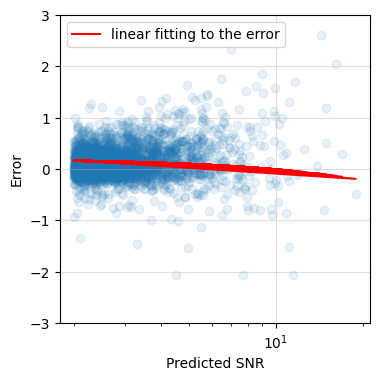

In [116]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred_>2) & (y_pred_<20)
idx = idx & (y_test_!=0)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], (y_pred_[idx]-0.0)-y_test_[idx], alpha=0.1)
# correction for the linear fitting
plt.plot(y_pred_[idx], a*y_pred_[idx]+b, 'r', label='linear fitting to the error')
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
# plt.xlim(6,10)
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("error_vs_snrET1_param4.png")
plt.show()

In [117]:
idx = (Y_>6)&(Y_<10)
y_pred = modelET1.predict(X_[idx])
y_pred_ = y_pred.flatten()-(a*y_pred.flatten()+b)
y_true = Y_[idx]
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_pred_.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1)[10:20])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
[[5.93298197 5.85101795 6.04834994]
 [8.13605881 8.10010052 8.06745302]
 [6.17404127 6.09711123 6.34537863]
 [6.57007599 6.50141621 7.3953399 ]
 [6.31843805 6.24452353 6.14583937]
 [7.56027985 7.51229811 7.36668992]
 [8.08286858 8.04579926 8.83326747]
 [4.62435389 4.51506233 6.58250399]
 [6.93653011 6.87552261 6.88068083]
 [5.94931698 5.8676939  6.00676755]]


In [120]:
# save the correction function
import pickle

def correction(x):
    a = -0.02088252 
    b = 0.20585957
    return a*x + b

pickle.dump(correction, open('correctionET1.pkl', 'wb'))

## H1

In [68]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_ET1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['H1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['H1']))

216908
216853


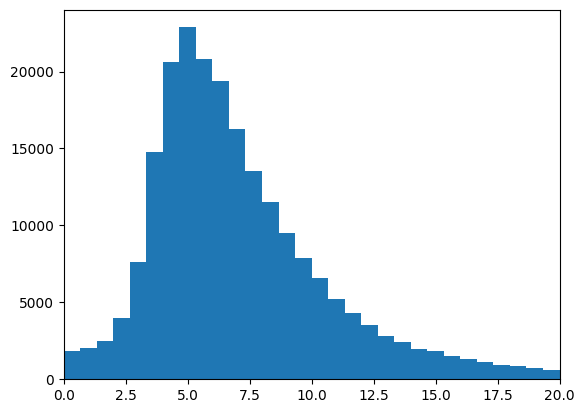

In [69]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['H1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [70]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['H1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['H1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [71]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XH1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get H1 snr for y train
    yH1 = params['H1'][idx]

    return(XH1, yH1)

In [72]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XH1, yH1 = input_output(idx, unlensed_params)
np.shape(XH1)

(216853, 5)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

In [74]:
import pickle
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
sc = scalerH1
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [88]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1_final.pkl', 'wb'))

In [68]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [69]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [70]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


6099/6099 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - accuracy: 0.0000e+00 - loss: 17.8660
Epoch 2/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step - accuracy: 0.0000e+00 - loss: 1.7365
Epoch 3/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 379us/step - accuracy: 1.4456e-05 - loss: 0.8292
Epoch 4/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step - accuracy: 9.6210e-06 - loss: 0.6602
Epoch 5/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 382us/step - accuracy: 1.1836e-05 - loss: 0.6046
Epoch 6/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 363us/step - accuracy: 3.1605e-05 - loss: 0.5594
Epoch 7/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - accuracy: 3.2714e-05 - loss: 0.5581
Epoch 8/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step - accuracy: 3.3103e-05 - loss: 0.5559
Epoch 9/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step - accuracy: 4.6910e-05 - loss: 0.5422
Epoch 10/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 3s 416us/step - accuracy: 4.9281e-05 - loss: 0.5353
Epoch 11/100
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 384us/step - 

In [74]:
# Save the model to a file
# ann.save('ann_modelH1_final.h5')

In [75]:
from tensorflow.keras.models import load_model
modelH1 = load_model('ann_modelH1_final.h5')

In [76]:
y_pred = modelH1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

  1/678 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
[[11.81305695 10.16776652]
 [ 4.54099417  4.67938633]
 [ 5.67993593  5.99524306]
 [17.3660202  13.28900541]
 [ 4.92294598  5.06414443]
 [ 1.74239469  1.69682416]
 [10.84076309 10.43839134]
 [20.37717819 20.71786841]
 [ 9.75965309  8.71856186]
 [ 6.39657259  6.51032279]
 [10.16740227 10.73303641]
 [ 3.94705582  4.09872407]
 [10.11041737 10.29067414]
 [ 4.89055157  4.9473158 ]
 [ 7.57538319  6.92448364]]


In [77]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.77%


In [78]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
X_, Y_ = input_output(np.arange(len(unlensed_params['H1'])), unlensed_params)
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
X_ = scalerH1.transform(X_)

idx = (Y_>6)&(Y_<10)
y_pred = modelH1.predict(X_[idx])
y_true = Y_[idx]
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1)[10:20])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
[[7.5986495  7.39146383]
 [6.85121918 7.14556099]
 [7.90196848 7.94706398]
 [6.45951223 7.16987328]
 [7.14868546 6.36548437]
 [6.43363285 6.61627912]
 [6.4347682  6.71736064]
 [8.3483429  7.80814359]
 [5.95901966 6.26596796]
 [5.52727032 6.82308405]]


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
50000
123


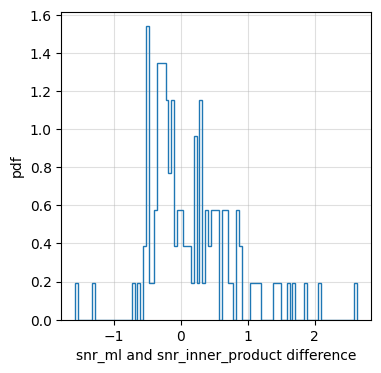

In [79]:
import matplotlib.pyplot as plt

y_pred_ = modelH1.predict(X_).flatten()
y_test_ = Y_
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
# idx = idx & (X_[:,2]>-2)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
# idx_ = abs(hist_)>3.0
# print(y_pred_[idx][idx_])
# print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [91]:
y_pred_ = modelH1.predict(X_).flatten()-0.0
y_test_ = Y_
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")
# median error
idx = (y_test_>4) & (y_test_<10)
np.median(np.abs(y_pred_[idx]-y_test_[idx]))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
Error: 0.0440%


0.23397480024714357

In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_ = modelH1.predict(X_).flatten()-0.0
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy_score((y_test_>8), (y_pred_>8))*100

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
[[49930    15]
 [    7    48]]


99.956

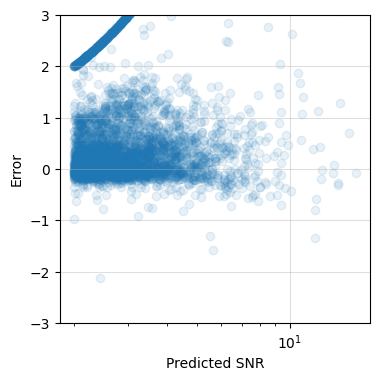

In [89]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred_>2) & (y_pred_<20)
# idx = idx & (X_[:,2]>-2)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
# plt.xlim(6,10)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrET1_param4.png")
plt.show()

## V1

In [92]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_ET1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['V1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['V1']))

216908
216879


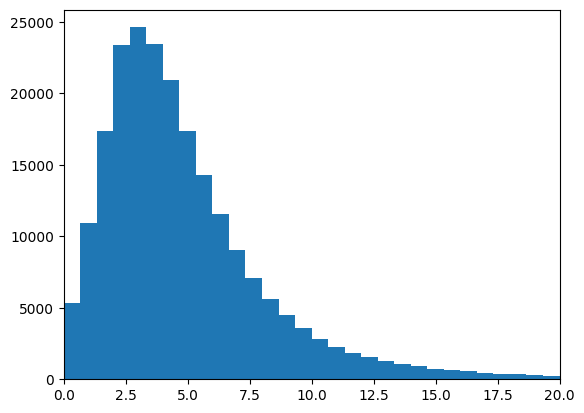

In [93]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['V1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [94]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['V1']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


In [95]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XV1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get V1 snr for y train
    yV1 = params['V1'][idx]

    return(XV1, yV1)

In [96]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XV1, yV1 = input_output(idx, unlensed_params)
np.shape(XV1)

(216879, 5)

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

In [98]:
import pickle
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
sc = scalerV1
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)   

In [24]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1_final.pkl', 'wb'))

In [25]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [26]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [27]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 361us/step - accuracy: 8.1362e-06 - loss: 8.2924
Epoch 2/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 377us/step - accuracy: 3.9841e-05 - loss: 0.9354
Epoch 3/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 387us/step - accuracy: 6.1525e-05 - loss: 0.5348
Epoch 4/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step - accuracy: 5.6701e-05 - loss: 0.4542
Epoch 5/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 371us/step - accuracy: 7.3709e-05 - loss: 0.4127
Epoch 6/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 408us/step - accuracy: 5.4604e-05 - loss: 0.3369
Epoch 7/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 417us/step - accuracy: 9.2999e-05 - loss: 0.3487
Epoch 8/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step - accuracy: 3.5551e-05 - loss: 0.3066
Epoch 9/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step - accuracy: 6.6813e-05 - loss: 0.3134
Epoch 10/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 363us/step - accuracy: 5.4068e-05 - loss: 0.3114
Epoch 11/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step - a

In [28]:
# Save the model to a file
#ann.save('ann_modelV1_final.h5')

In [99]:
from tensorflow.keras.models import load_model
modelV1 = load_model('ann_modelV1_final.h5')

In [100]:
y_pred = modelV1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
[[3.72602892 3.75191528]
 [2.80562401 2.73299109]
 [3.7019949  3.7928136 ]
 [3.37962151 3.43612569]
 [3.35274076 3.3695103 ]
 [2.68746638 2.11529832]
 [3.50592041 3.54437203]
 [1.68350077 1.67457096]
 [0.51043439 0.42067569]
 [1.38600183 1.25225281]
 [6.24442625 5.79314661]
 [4.01840305 3.68750865]
 [1.65803421 1.64318669]
 [7.87962437 7.62591653]
 [2.3158021  2.27467684]]


In [101]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.72%


In [102]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
X_, Y_ = input_output(np.arange(len(unlensed_params['V1'])), unlensed_params)
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
X_ = scalerV1.transform(X_)

idx = (Y_>4)&(Y_<8)
y_pred = modelV1.predict(X_[idx])-0.3
y_true = Y_[idx]
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1)[10:20])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
[[3.96775746 4.26540149]
 [4.48241901 4.4400537 ]
 [7.96259308 7.75734906]
 [7.16587067 7.41666949]
 [5.84391356 6.15134315]
 [6.3415041  6.65785873]
 [3.68682933 4.24602721]
 [4.25472021 4.51136506]
 [4.62181807 4.99683141]
 [4.20406151 4.54760193]]


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
50000
59


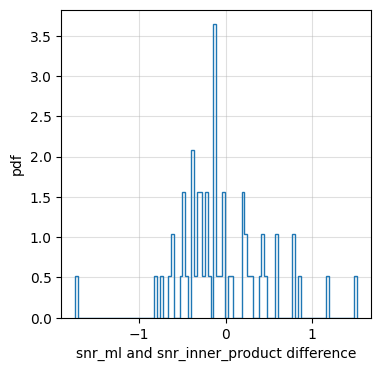

In [103]:
import matplotlib.pyplot as plt

y_pred_ = modelV1.predict(X_).flatten()-0.1
y_test_ = Y_
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
# idx = idx & (X_[:,2]>-2)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
# idx_ = abs(hist_)>3.0
# print(y_pred_[idx][idx_])
# print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [111]:
y_pred_ = modelV1.predict(X_).flatten()-0.1
y_test_ = Y_
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>6) != (y_test_>6))
error = len2/len1*100
print(f"Error: {error:.4f}%")
# median error
idx = (y_test_>4) & (y_test_<10)
np.median(np.abs(y_pred_[idx]-y_test_[idx]))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
Error: 0.2300%


0.22296366356346242

In [110]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_ = modelV1.predict(X_).flatten()-0.1
y_test_ = Y_
cm = confusion_matrix((y_test_>6), ((y_pred_)>6))
print(cm)
accuracy_score((y_test_>6), (y_pred_>6))*100

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
[[49811   112]
 [    3    74]]


99.77000000000001

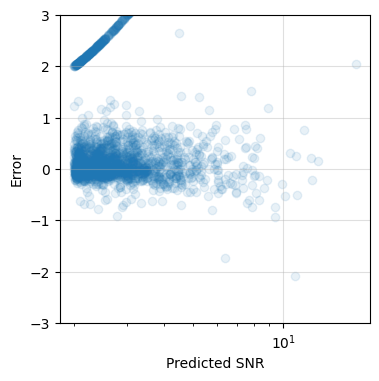

In [112]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred_>2) & (y_pred_<20)
# idx = idx & (X_[:,2]>-2)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
# plt.xlim(6,10)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrET1_param4.png")
plt.show()

## Load all models and test them

In [4]:
from tensorflow.keras.models import load_model
modelET1 = load_model('ann_modelET1_final.h5')
modelH1 = load_model('ann_modelH1_final.h5')
modelV1 = load_model('ann_modelV1_final.h5')

# load the scaler
import pickle
scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))

## BBH

In [5]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpam

In [6]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    ET1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T    

    X = np.array([ET1, H1, V1])

    # output data
    # get ET1 snr for y train 
    y = np.sqrt(np.array(params['ET1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y)

In [7]:
# generating new data
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

In [8]:
## Uncomment to generate new data if not already generated
# size_ = 50000
# ler.batch_size = 50000
# ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

In [9]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [10]:
X_, Y_ = input_output_net(np.arange(len(unlensed_params['ET1'])), unlensed_params)

In [11]:
def input_output_netANN(x_array):
    x = scalerET1.transform(x_array[0])
    yET1 = modelET1.predict(x)-0.1
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)-0.
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)-0.1
    y = np.sqrt(yET1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [12]:
_, snrANN =input_output_netANN(X_)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


In [13]:
y_pred = snrANN.flatten()
y_test = Y_

In [14]:
len(y_test)

50000

In [15]:
len(y_pred)

50000

In [16]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred>4) & (y_pred<12)
popt, pcov = curve_fit(func, y_pred[idx], y_pred[idx]-y_test[idx])
print(popt)

[-0.0272621   0.52812907]


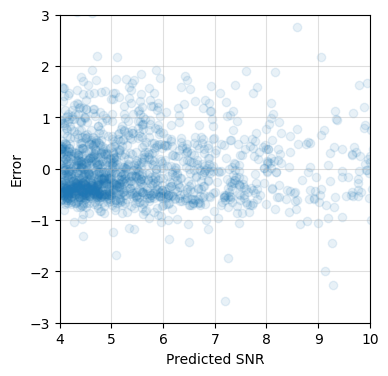

In [17]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred = y_pred.copy().flatten()
y_pred = y_pred-(popt[0]*y_pred+popt[1])
idx = (y_pred>4) & (y_pred<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred[idx], y_pred[idx]-y_test[idx], alpha=0.1)
#plt.scatter(y_test[idx], y_pred[idx]-y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

50000
1553


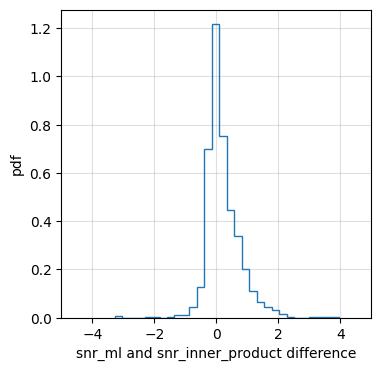

In [18]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [19]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1180%


In [20]:
len1 = len(y_pred)
len2 = np.sum(((y_pred-(popt[0]*y_pred+popt[1]))>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1080%


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.0)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[49709    42]
 [   17   232]]


0.99882

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.2)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[49719    32]
 [   26   223]]


0.99882

In [26]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_test<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[idx][:10])

[[8.58148289 8.18036323]
 [8.33991051 7.65743028]
 [9.12020779 8.32999146]
 [8.44598007 7.99691594]
 [7.79193974 7.79685629]
 [6.94455051 7.19353841]
 [8.38002968 7.09539475]
 [7.44811821 7.15994012]
 [7.13248825 7.12610658]
 [8.07463837 7.52413705]]


In [25]:
y_pred_ = y_pred-(popt[0]*y_pred+popt[1])
idx = (y_test>7) & (y_test<9)
print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_test.reshape(len(y_test),1)),1)[idx][:10])

[[8.28730297 8.18036323]
 [8.03914452 7.65743028]
 [8.84071445 8.32999146]
 [8.14810658 7.99691594]
 [7.47623539 7.79685629]
 [6.60574436 7.19353841]
 [8.08035755 7.09539475]
 [7.1230402  7.15994012]
 [6.79880571 7.12610658]
 [7.76664066 7.52413705]]


In [27]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_test<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1)-0.2, y_test.reshape(len(y_test),1)),1)[idx][:10])

[[8.38148308 8.18036323]
 [8.1399107  7.65743028]
 [8.92020798 8.32999146]
 [8.24598026 7.99691594]
 [7.59193993 7.79685629]
 [6.7445507  7.19353841]
 [8.18002987 7.09539475]
 [7.2481184  7.15994012]
 [6.93248844 7.12610658]
 [7.87463856 7.52413705]]


## BNS

In [540]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [541]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


  1%|▌                                                          | 527/50000 [00:10<17:00, 48.47it/s]


KeyboardInterrupt: 

In [ ]:
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined